In [1]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries

In [2]:
def save_dataset(symbol):
    api_key = 'P33J9T7IVI663Y0A'

    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')

    data.to_csv(f'./DataOutput/{symbol}_daily.csv')
    print (data.head ())
    print (f'./DataOutput/{symbol}_daily.csv')

In [3]:
def csv_to_dataset_openclose(csv_path):
    data = pd.read_csv(csv_path)
    dateList = []
    yList = []
    row_count = len(data['1. open'])

    for i in range (row_count):
      dateList.append (str(data.date[i]) + ' 09:30:00')
      dateList.append (str(data.date[i]) + ' 16:00:00')
      yList.append (data['1. open'][i])
      yList.append (data['4. close'][i])

      data_openclose = pd.DataFrame ({'ds':dateList,'y':yList})
    
    data_volume = data.drop (["1. open",  "2. high",   "3. low",  "4. close"], axis=1)
    data_volume.rename (columns = {"date": "ds", "5. volume": "y"}, inplace = True)

    data_high = data.drop (["1. open",  "5. volume",   "3. low",  "4. close"], axis=1)
    data_high.rename (columns = {"date": "ds", "2. high": "y"}, inplace = True)    
    
    data_low = data.drop (["1. open",  "5. volume",   "2. high",  "4. close"], axis=1)
    data_low.rename (columns = {"date": "ds", "3. low": "y"}, inplace = True)    
    
    return data,data_openclose, data_volume, data_high, data_low

In [4]:
save_dataset('AC')

            1. open  2. high   3. low  4. close  5. volume
date                                                      
2021-03-19  35.8400  38.1300  35.2506     37.15    58352.0
2021-03-18  36.3700  36.6300  35.8450     36.26    17318.0
2021-03-17  35.9500  37.0339  35.9000     36.50    14375.0
2021-03-16  36.7100  37.4000  36.0300     36.30    13363.0
2021-03-15  36.5265  36.8900  36.0600     36.63    20092.0
./DataOutput/AC_daily.csv


In [5]:
def csv_to_dataset_volume(csv_path):
    data = pd.read_csv(csv_path)

    return data

In [6]:
data,data_openclose, data_volume, data_high, data_low = csv_to_dataset_openclose('./DataOutput/AC_daily.csv')

In [7]:
print (data_openclose.head ())
print (data_volume.head ())
print (data_high.head ())
print (data_low.head ())

                    ds      y
0  2021-03-19 09:30:00  35.84
1  2021-03-19 16:00:00  37.15
2  2021-03-18 09:30:00  36.37
3  2021-03-18 16:00:00  36.26
4  2021-03-17 09:30:00  35.95
           ds        y
0  2021-03-19  58352.0
1  2021-03-18  17318.0
2  2021-03-17  14375.0
3  2021-03-16  13363.0
4  2021-03-15  20092.0
           ds        y
0  2021-03-19  38.1300
1  2021-03-18  36.6300
2  2021-03-17  37.0339
3  2021-03-16  37.4000
4  2021-03-15  36.8900
           ds        y
0  2021-03-19  35.2506
1  2021-03-18  35.8450
2  2021-03-17  35.9000
3  2021-03-16  36.0300
4  2021-03-15  36.0600


In [8]:
model_openclose = Prophet(daily_seasonality=True)
model_volume = Prophet(daily_seasonality=True)
model_high = Prophet(daily_seasonality=True)
model_low = Prophet(daily_seasonality=True)

model_openclose.fit(data_openclose)
model_volume.fit(data_volume)
model_high.fit(data_high)
model_low.fit(data_low)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [9]:
data_openclose.describe()

,y
count,2668.000000
mean,35.845595
std,3.976551
min,25.080000
25%,33.900000
50%,35.900000
75%,38.250000
max,64.900000


In [10]:
future_openclose_df = model_openclose.make_future_dataframe(periods=90)
future_volume_df = model_volume.make_future_dataframe(periods=90)
future_high_df = model_high.make_future_dataframe(periods=90)
future_low_df = model_low.make_future_dataframe(periods=90)

In [11]:
predictions_openclose = model_openclose.predict(future_openclose_df)
predictions_volume = model_volume.predict(future_volume_df)
predictions_high = model_high.predict(future_high_df)
predictions_low = model_low.predict(future_low_df)

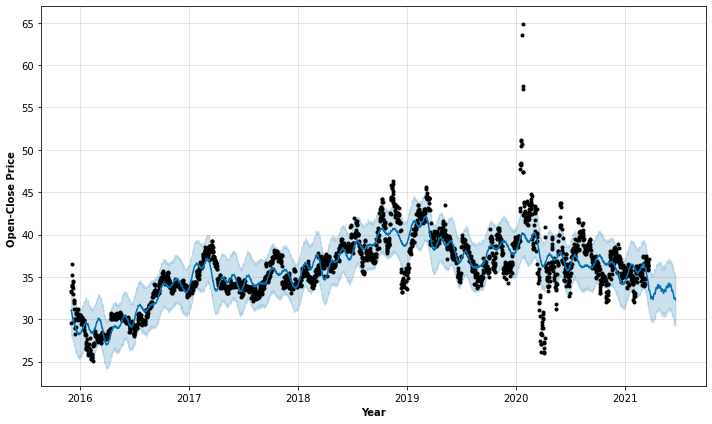

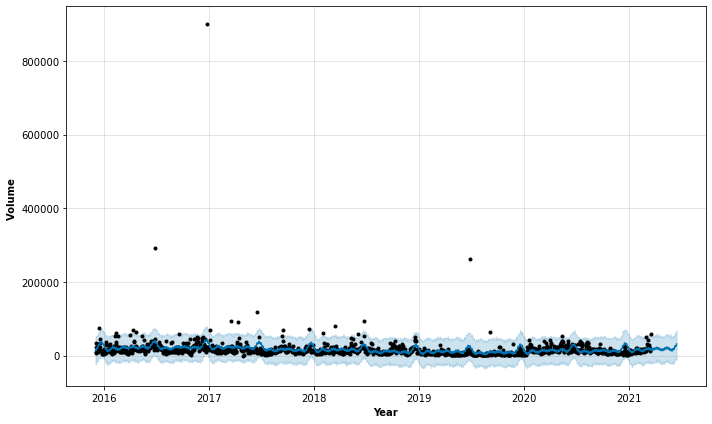

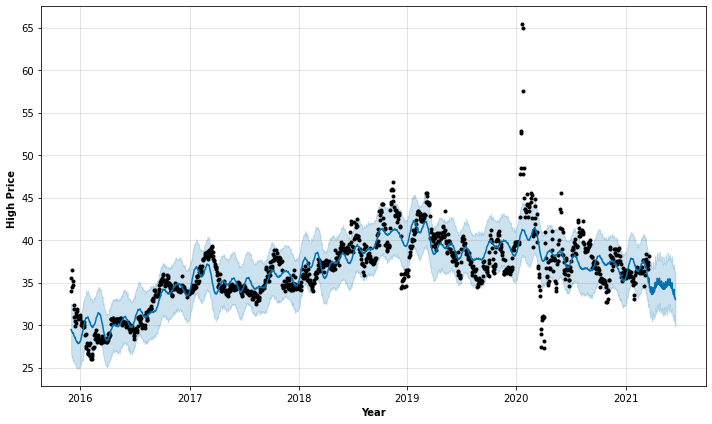

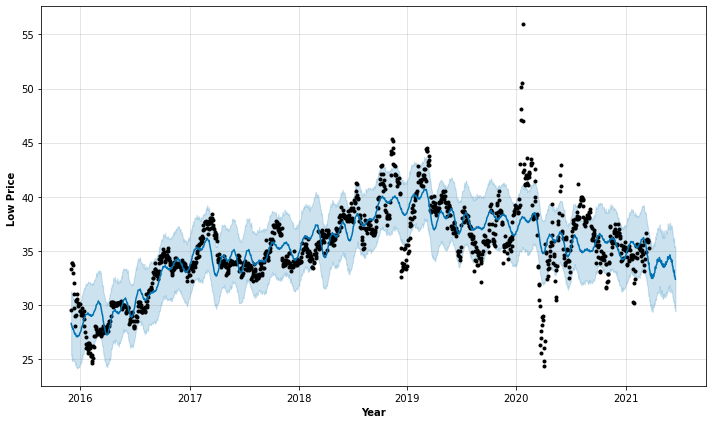

In [12]:
ax =model_openclose.plot(predictions_openclose)
plt.ylabel("Open-Close Price ", rotation='vertical', weight='bold')
plt.xlabel("Year",weight='bold')
model_volume.plot(predictions_volume)
plt.ylabel("Volume ", rotation='vertical', weight='bold')
plt.xlabel("Year",weight='bold')
model_high.plot(predictions_high)
plt.ylabel("High Price ", rotation='vertical', weight='bold')
plt.xlabel("Year",weight='bold')
model_low.plot(predictions_low)
plt.ylabel("Low Price ", rotation='vertical', weight='bold')
plt.xlabel("Year",weight='bold')
plt.show()

# Multi linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
stock=data.copy()
stock.head()
stock.rename(columns={'date': 'Date',
                        '1. open': 'Open',
                       '2. high': 'High',
                        '3. low': 'Low',
                        '4. close': 'Close',
                        '5. volume': 'Volume'}, inplace=True)
#percent change

In [15]:

# stock['high-low_pct']=(stock['High']-stock['Low']).pct_change()
#moving average
stock['ma_5']=stock['Close'].ewm(span=5).mean().shift(periods=1)
#std dev of the price over the past 5 days (how volitile the stock is)
stock['price_std_5']=stock['Close'].rolling(center=False, window=5).std().shift(periods=1)
#daily volume percent change
stock['volume_change_pct']=stock['Volume'].pct_change()
#Average Volume for th past 5 days
stock['volume_avg_5']=stock['Volume'].rolling(center=False, window=5).mean().shift(periods=1)
# stock['volume Close']=stock['Volume'].rolling(center=False,window=5).std().shift(periods=1)
stock.head(10)
stock_refined=stock.dropna()